<a href="https://colab.research.google.com/github/patrickphatnguyen/Knowledge-Distillation-Keras/blob/master/Knowledge_Distillation_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Distilling Knowledge in Neural Network

The term "Knowledge Distillation" (a.k.a Teacher-Student Model) was first introduced by (Bu-cilu et al., 2006; Ba & Caruana,2014) and has been popularized by (Hinton et al., 2015), as a way to let smaller deep learning models learn how bigger ones generalize to large datasets, hence increase the performance of the smaller one. In this notebook, I'll try to explain the idea of knowledge distillation alongside with hands-on implementation of it.

# The main idea


# Install and import requirements


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D,Dense,Softmax,Flatten,MaxPooling2D,Dropout,Activation, Lambda, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import kullback_leibler_divergence as KLD_Loss, categorical_crossentropy as logloss
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy
import seaborn as sns

C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


#  Load and preprocess the data

In [2]:
NUM_CLASSES = 10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Normalize the dataset
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape each example to WIDTH*HEIGHT*CHANNELS for Convolution operation
# x_test = x_test.reshape(-1,,28,1)
# x_train = x_train.reshape(-1,28,28,1)


x_train shape: (50000, 32, 32, 3) y_train shape: (50000, 1)


# Create teacher model

In [3]:
Teacher = Sequential() # Must define the input shape in the first layer of the neural network
Teacher.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(32,32,3)))
Teacher.add(MaxPooling2D(pool_size=2))
Teacher.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
Teacher.add(MaxPooling2D(pool_size=2))
Teacher.add(Flatten())
Teacher.add(Dense(256, activation='relu'))
Teacher.add(Dropout(0.5))
Teacher.add(Dense(10))
Teacher.add(Activation('softmax'))

Teacher.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# Take a look at the model summary

Teacher.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1048832   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [4]:
myCP = ModelCheckpoint(save_best_only=True,filepath='teacher.h5',monitor = 'val_acc')
# epoch 할때마다 좋은 모델만 저장
Teacher.fit(x_train,
         y_train,
         batch_size=128,
         epochs=20,
         validation_split = 0.2,
         callbacks=[myCP])

Epoch 1/20
312/313 [============================>.] - ETA: 0s - loss: 1.6765 - accuracy: 0.3943

W1013 20:59:30.970583 31620 callbacks.py:1289] Can save best model only with val_acc available, skipping.


313/313 [==============================] - 23s 73ms/step - loss: 1.6762 - accuracy: 0.3945 - val_loss: 1.4186 - val_accuracy: 0.5006
Epoch 2/20
312/313 [============================>.] - ETA: 0s - loss: 1.3564 - accuracy: 0.5157

W1013 20:59:52.225266 31620 callbacks.py:1289] Can save best model only with val_acc available, skipping.


313/313 [==============================] - 21s 68ms/step - loss: 1.3563 - accuracy: 0.5156 - val_loss: 1.2034 - val_accuracy: 0.5785
Epoch 3/20
312/313 [============================>.] - ETA: 0s - loss: 1.2248 - accuracy: 0.5644

W1013 21:00:13.477142 31620 callbacks.py:1289] Can save best model only with val_acc available, skipping.


313/313 [==============================] - 21s 68ms/step - loss: 1.2246 - accuracy: 0.5644 - val_loss: 1.1310 - val_accuracy: 0.6017
Epoch 4/20
312/313 [============================>.] - ETA: 0s - loss: 1.1382 - accuracy: 0.5958

W1013 21:00:35.430983 31620 callbacks.py:1289] Can save best model only with val_acc available, skipping.


313/313 [==============================] - 22s 70ms/step - loss: 1.1381 - accuracy: 0.5959 - val_loss: 1.0573 - val_accuracy: 0.6330
Epoch 5/20
312/313 [============================>.] - ETA: 0s - loss: 1.0769 - accuracy: 0.6193

W1013 21:00:57.468545 31620 callbacks.py:1289] Can save best model only with val_acc available, skipping.


313/313 [==============================] - 22s 70ms/step - loss: 1.0768 - accuracy: 0.6194 - val_loss: 1.0007 - val_accuracy: 0.6473
Epoch 6/20
312/313 [============================>.] - ETA: 0s - loss: 1.0200 - accuracy: 0.6418

W1013 21:01:20.124521 31620 callbacks.py:1289] Can save best model only with val_acc available, skipping.


313/313 [==============================] - 23s 72ms/step - loss: 1.0200 - accuracy: 0.6418 - val_loss: 0.9635 - val_accuracy: 0.6612
Epoch 7/20
312/313 [============================>.] - ETA: 0s - loss: 0.9753 - accuracy: 0.6593

W1013 21:01:41.694013 31620 callbacks.py:1289] Can save best model only with val_acc available, skipping.


313/313 [==============================] - 22s 69ms/step - loss: 0.9753 - accuracy: 0.6592 - val_loss: 0.9526 - val_accuracy: 0.6621
Epoch 8/20
312/313 [============================>.] - ETA: 0s - loss: 0.9274 - accuracy: 0.6737

W1013 21:02:04.387948 31620 callbacks.py:1289] Can save best model only with val_acc available, skipping.


313/313 [==============================] - 23s 72ms/step - loss: 0.9276 - accuracy: 0.6737 - val_loss: 0.9373 - val_accuracy: 0.6699
Epoch 9/20
312/313 [============================>.] - ETA: 0s - loss: 0.8907 - accuracy: 0.6838

W1013 21:02:26.148052 31620 callbacks.py:1289] Can save best model only with val_acc available, skipping.


313/313 [==============================] - 22s 69ms/step - loss: 0.8908 - accuracy: 0.6838 - val_loss: 0.9206 - val_accuracy: 0.6770
Epoch 10/20
312/313 [============================>.] - ETA: 0s - loss: 0.8582 - accuracy: 0.6947

W1013 21:02:48.332086 31620 callbacks.py:1289] Can save best model only with val_acc available, skipping.


313/313 [==============================] - 22s 71ms/step - loss: 0.8582 - accuracy: 0.6948 - val_loss: 0.8893 - val_accuracy: 0.6917
Epoch 11/20
312/313 [============================>.] - ETA: 0s - loss: 0.8310 - accuracy: 0.7074

W1013 21:03:10.410475 31620 callbacks.py:1289] Can save best model only with val_acc available, skipping.


313/313 [==============================] - 22s 70ms/step - loss: 0.8309 - accuracy: 0.7074 - val_loss: 0.8856 - val_accuracy: 0.6941
Epoch 12/20
312/313 [============================>.] - ETA: 0s - loss: 0.7882 - accuracy: 0.7199

W1013 21:03:31.901451 31620 callbacks.py:1289] Can save best model only with val_acc available, skipping.


313/313 [==============================] - 21s 68ms/step - loss: 0.7881 - accuracy: 0.7199 - val_loss: 0.8844 - val_accuracy: 0.6927
Epoch 13/20
312/313 [============================>.] - ETA: 0s - loss: 0.7641 - accuracy: 0.7301

W1013 21:03:53.393600 31620 callbacks.py:1289] Can save best model only with val_acc available, skipping.


313/313 [==============================] - 21s 68ms/step - loss: 0.7640 - accuracy: 0.7301 - val_loss: 0.8681 - val_accuracy: 0.7021
Epoch 14/20
312/313 [============================>.] - ETA: 0s - loss: 0.7290 - accuracy: 0.7406

W1013 21:04:16.679310 31620 callbacks.py:1289] Can save best model only with val_acc available, skipping.


313/313 [==============================] - 23s 74ms/step - loss: 0.7290 - accuracy: 0.7405 - val_loss: 0.8538 - val_accuracy: 0.7058
Epoch 15/20
312/313 [============================>.] - ETA: 0s - loss: 0.7056 - accuracy: 0.7503

W1013 21:04:39.619531 31620 callbacks.py:1289] Can save best model only with val_acc available, skipping.


313/313 [==============================] - 23s 73ms/step - loss: 0.7056 - accuracy: 0.7503 - val_loss: 0.8584 - val_accuracy: 0.7058
Epoch 16/20
312/313 [============================>.] - ETA: 0s - loss: 0.6751 - accuracy: 0.7556

W1013 21:05:01.537629 31620 callbacks.py:1289] Can save best model only with val_acc available, skipping.


313/313 [==============================] - 22s 70ms/step - loss: 0.6753 - accuracy: 0.7554 - val_loss: 0.8754 - val_accuracy: 0.6982
Epoch 17/20
312/313 [============================>.] - ETA: 0s - loss: 0.6574 - accuracy: 0.7641

W1013 21:05:23.500114 31620 callbacks.py:1289] Can save best model only with val_acc available, skipping.


313/313 [==============================] - 22s 70ms/step - loss: 0.6576 - accuracy: 0.7642 - val_loss: 0.8648 - val_accuracy: 0.7077
Epoch 18/20
312/313 [============================>.] - ETA: 0s - loss: 0.6310 - accuracy: 0.7740

W1013 21:05:45.652080 31620 callbacks.py:1289] Can save best model only with val_acc available, skipping.


313/313 [==============================] - 22s 71ms/step - loss: 0.6306 - accuracy: 0.7742 - val_loss: 0.8562 - val_accuracy: 0.7110
Epoch 19/20
312/313 [============================>.] - ETA: 0s - loss: 0.6072 - accuracy: 0.7828

W1013 21:06:07.496250 31620 callbacks.py:1289] Can save best model only with val_acc available, skipping.


313/313 [==============================] - 22s 70ms/step - loss: 0.6074 - accuracy: 0.7826 - val_loss: 0.8867 - val_accuracy: 0.7031
Epoch 20/20
312/313 [============================>.] - ETA: 0s - loss: 0.5797 - accuracy: 0.7906

W1013 21:06:29.240191 31620 callbacks.py:1289] Can save best model only with val_acc available, skipping.


313/313 [==============================] - 22s 69ms/step - loss: 0.5797 - accuracy: 0.7907 - val_loss: 0.8720 - val_accuracy: 0.7122


In [6]:
# Retrieve best model from saved
# Teacher = load_model('teacher.h5')

# Evaluation with test set
Teacher.evaluate(x_test,y_test)

313/313 [==============================] - 1s 5ms/step - loss: 0.8738 - accuracy: 0.7061


[0.8738300800323486, 0.7060999870300293]

# Understand temperature

W1013 21:08:17.286367 31620 def_function.py:120] 5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024E79A9A2F0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
W1013 21:08:17.353188 31620 def_function.py:120] 6 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024E79AD4D08> triggered tf.function retracing. Tracing is 

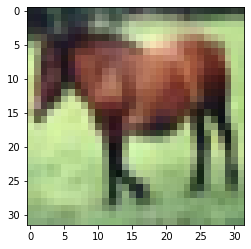

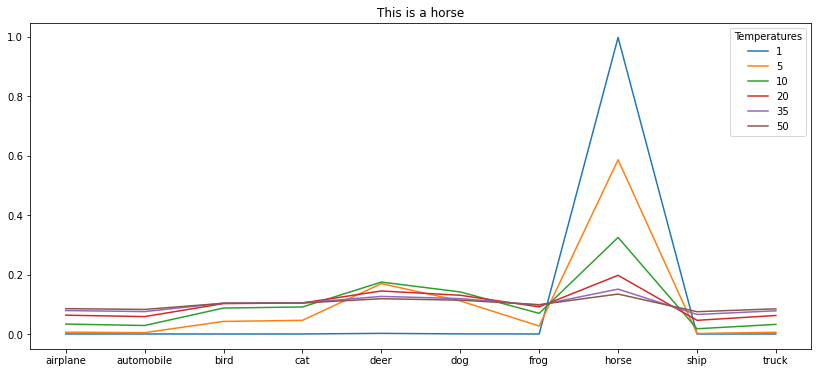

In [9]:
Teacher_logits = Model(Teacher.input,Teacher.layers[-2].output)
# 뒤에서 두번째 layer까지
# 선생님 지식

logits_plot = []

class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]										


# Choose the item to visualize temperature
# 온도를 높여 증류하는 식
item_idx = 7

item_image = x_train[item_idx]

plt.imshow(item_image)

Temperatures = [1,5,10,20,35,50]


for Temperature in Temperatures:
  # Create temperature layer that produces logits with temperature
    T_layer = Lambda(lambda x:x/Temperature)(Teacher_logits.output)
    # Lambda : layer값을 함수로 계산해서 다음 layer로
  
  # Create a softmax layer
    Softmax_layer = Softmax()(T_layer)
  # Add the teacher T_layer to the whole model
    Teacher_logits_soften = Model(Teacher.input,Softmax_layer)
                             
  # Append for plotting
    logits_plot.append(Teacher_logits_soften.predict(np.array([item_image])))
  
plt.figure(figsize=(14, 6))

for i in range(len(Temperatures)):
    sns.lineplot(class_names,logits_plot[i][0],legend="full")
    plt.title('This is a '+ class_names[y_train[item_idx][0]])
    plt.legend(Temperatures,title="Temperatures")
    
#

# Create a teacher model that create softened output
As mentioned in **Hinton's paper**:  "When the distilled net had 300 or more units in each of its two hidden layers, all temperatures above gave fairly similar results. But when this was radically reduced to 30 units per layer, temperatures in the range 2.5 to 4 worked significantly better than high or lower temperatures."  
In this notebook, I'll use temperature **3.25**, feel free to change to the Temperature to any number of your interest.

- 2.5에서 4까지가 나누기 좋다

In [10]:
Temperature = 3.25
T_layer = Lambda(lambda x:x/Temperature)(Teacher_logits.output)
Softmax_layer = Activation('softmax')(T_layer)
Teacher_soften = Model(Teacher.input,Softmax_layer)

In [11]:
# Predict and convert to sparse categorical matrix
y_train_new = Teacher_soften.predict(x_train)
y_test_new = Teacher_soften.predict(x_test)

y_train_new = np.c_[to_categorical(y_train),y_train_new]
y_test_new = np.c_[to_categorical(y_test),y_test_new]

W1013 21:08:22.753547 31620 def_function.py:120] 7 out of the last 7 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024E79DC1378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


# Create a student model that produces with and without soften output

The student model we'll in this notebook is a really shallow neural network with only 1 hidden layers with 64 units, followed by a 10 softmax unit for the output

In [12]:
Student = Sequential() #a Must define the input shape in the first layer of the neural network
Student.add(Flatten(input_shape=(32,32,3)))
Student.add(Dense(64, activation='relu'))
Student.add(Dense(10))
Student.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                196672    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 197,322
Trainable params: 197,322
Non-trainable params: 0
_________________________________________________________________


In [13]:
student_logits = Student.layers[-1].output

# Compute softmax
probs = Activation("softmax")(student_logits)

# Compute softmax with softened logits
logits_T = Lambda(lambda x:x/Temperature)(student_logits)
probs_T = Activation("softmax")(logits_T)

CombinedLayers = concatenate([probs,probs_T])

StudentModel = Model(Student.input,CombinedLayers)

<center><img src="https://nervanasystems.github.io/distiller/imgs/knowledge_distillation.png" width=500></center>
<center> 

$$ \text{Let } a_{t}  \text{ and } a_{s} \text{ be the logits (the inputs to the final softmax) of the teacher and student network, respectively, with the ground-truth label } y_{r} .\text{ We calculate the cross-entropy between the softmax} (a_{s},y_{r}) \text{ and } y_{r} \text{ as follow:}$$
$$ \mathcal{L}_{SL}=\mathcal{H}(\text{softmax}(a_{s},y_{r})) $$

$$ \text{In knowledge distillation (in all 3 papers), we tries to match the softened outputs of the student } y_{s} = \text{softmax}(a_{s}/\mathcal{T})   \text{ and teacher's softened outputs }  y_{t}=\text{softmax}(a_{t}/\mathcal{T}) \text{via a KL-divergence loss}$$
$$\mathcal{L}_{KD}=\mathcal{T}^2\text{KL}(y_{s},y_{t})$$ 
$$ \text{The student model will then be trained on a "combined" loss between } \mathcal{L}_{SL} \text{ and } \mathcal{L}_{KD} \text{ with } \lambda \text{ representing the trade off of 2 losses }$$
$$\mathcal{L}_{\text{student}} = \lambda\mathcal{L}_{SL} + (1-\lambda)\mathcal{L}_{KD}$$

In [15]:
def KD_loss(y_true,y_pred,lambd=0.5,T=10.0):
  y_true,y_true_KD = y_true[:,:NUM_CLASSES],y_true[:,NUM_CLASSES:]
  y_pred,y_pred_KD = y_pred[:,:NUM_CLASSES],y_pred[:,NUM_CLASSES:]
  # Classic cross-entropy (without temperature)
  CE_loss = logloss(y_true,y_pred)
  # KL-Divergence loss for softened output (with temperature)
  KL_loss = T**2*KLD_Loss(y_true_KD,y_pred_KD)
  
  return lambd*CE_loss + (1-lambd)*KL_loss

def accuracy(y_true,y_pred):
  return categorical_accuracy(y_true,y_pred)
  

In [16]:
StudentModel.compile(optimizer='adam',loss=lambda y_true,y_pred: KD_loss(y_true, y_pred,lambd=0.5,T=Temperature),metrics=[accuracy])

In [17]:
myCP = ModelCheckpoint(save_best_only=True,filepath='student.h5',monitor = 'val_accuracy')

StudentModel.fit(x_train,y_train_new,epochs=50,validation_split=0.15,batch_size=128,callbacks=[myCP])

Epoch 1/50
333/333 [==============================] - 1s 4ms/step - loss: 3.8932 - accuracy: 0.3107 - val_loss: 3.6282 - val_accuracy: 0.3135
Epoch 2/50
333/333 [==============================] - 1s 3ms/step - loss: 3.4850 - accuracy: 0.3613 - val_loss: 3.2834 - val_accuracy: 0.3691
Epoch 3/50
333/333 [==============================] - 1s 3ms/step - loss: 3.3096 - accuracy: 0.3826 - val_loss: 3.2623 - val_accuracy: 0.3548
Epoch 4/50
333/333 [==============================] - 1s 3ms/step - loss: 3.1935 - accuracy: 0.3936 - val_loss: 3.0670 - val_accuracy: 0.3896
Epoch 5/50
333/333 [==============================] - 1s 3ms/step - loss: 3.1023 - accuracy: 0.4053 - val_loss: 2.9803 - val_accuracy: 0.3995
Epoch 6/50
333/333 [==============================] - 1s 3ms/step - loss: 3.0318 - accuracy: 0.4109 - val_loss: 2.9798 - val_accuracy: 0.3905
Epoch 7/50
333/333 [==============================] - 1s 3ms/step - loss: 2.9779 - accuracy: 0.4157 - val_loss: 3.0144 - val_accuracy: 0.3895
Epoch 

In [18]:
StudentModel.load_weights('student.h5')
StudentModel.evaluate(x_train,y_train_new)


1563/1563 [==============================] - 1s 813us/step - loss: 2.4969 - accuracy: 0.4625


[2.4969213008880615, 0.46248000860214233]

# Create a standalone student

In [0]:
AloneModel = Sequential() #a Must define the input shape in the first layer of the neural netAloneStudent = Sequential() #a Must define the input shape in the first layer of the neural network
AloneModel.add(Flatten(input_shape=(32,32,3)))
AloneModel.add(Dense(64, activation='relu'))
AloneModel.add(Dense(10,activation="softmax"))
AloneModel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                196672    
_________________________________________________________________
dense_13 (Dense)             (None, 10)                650       
Total params: 197,322
Trainable params: 197,322
Non-trainable params: 0
_________________________________________________________________


In [0]:
AloneModel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

myCP = ModelCheckpoint(_best_only=True,filepath='alone.h5',monitor = 'val_acc')

AloneModel.fit(x_train,y_train,epochs=50,validation_split=0.15,batch_size=128,callbacks=[myCP])


Train on 42500 samples, validate on 7500 samples
Epoch 1/50
42500/42500 [==============================] - 2s 52us/sample - loss: 2.0431 - acc: 0.2463 - val_loss: 1.9507 - val_acc: 0.2873
Epoch 2/50
42500/42500 [==============================] - 1s 34us/sample - loss: 1.8805 - acc: 0.3196 - val_loss: 1.9021 - val_acc: 0.3144
Epoch 3/50
42500/42500 [==============================] - 1s 34us/sample - loss: 1.8343 - acc: 0.3402 - val_loss: 1.8557 - val_acc: 0.3289
Epoch 4/50
42500/42500 [==============================] - 1s 34us/sample - loss: 1.8064 - acc: 0.3496 - val_loss: 1.8348 - val_acc: 0.3376
Epoch 5/50
42500/42500 [==============================] - 1s 35us/sample - loss: 1.7856 - acc: 0.3571 - val_loss: 1.8426 - val_acc: 0.3353
Epoch 6/50
42500/42500 [==============================] - 1s 33us/sample - loss: 1.7756 - acc: 0.3619 - val_loss: 1.8208 - val_acc: 0.3356
Epoch 7/50
42500/42500 [==============================] - 1s 33us/sample - loss: 1.7637 - acc: 0.3663 - val_loss: 1.8

In [0]:
AloneModel = load_model("alone.h5")
AloneModel.evaluate(x_test,y_test)

10000/10000 [==============================] - 1s 66us/sample - loss: 1.6973 - acc: 0.3934


[1.6973005071640015, 0.3934]

# References
[Nervanasystem github's
](https://nervanasystems.github.io/distiller/knowledge_distillation.html)

[Hinton et. al. - 
Distilling the Knowledge in a Neural Network](https://arxiv.org/abs/1503.02531)

[Seyed-Iman Mirzadeh et. al. - Improved Knowledge Distillation via Teacher Assistant:Bridging the Gap Between Student and Teacher](https://arxiv.org/abs/1902.03393)